In [81]:
import pandas as pd
import collections
import matplotlib.pyplot as plt
import sklearn.ensemble as ske
import numpy as np
import sklearn.metrics as skm


In [82]:
df = pd.read_csv("/Users/liamtabibzadeh/Documents/sml/sml-project-g20/data/train.csv", na_values='?')
for i in range(len(df)):

    if df.loc[i,"Lead"]=="Female":

        df.loc[i,"Number words female"]=df.loc[i,"Number words female"]+df.loc[i,"Number of words lead"]
    else:
        df.loc[i,"Number words male"]=df.loc[i,"Number words male"]+df.loc[i,"Number of words lead"]

df["difference_words_m_f"]=df.iloc[:,7]-df.iloc[:,0]

mean_difference=np.mean(df.difference_words_m_f)
def compute_epsilon(alpha,n,a,b):
    return np.sqrt((b-a)**2*np.log(2/alpha)/(2*n))

alpha = 0.05
n = len(df)
a = min(df.difference_words_m_f)
b = max(df.difference_words_m_f)
delta = compute_epsilon(alpha,n,a,b)
con=(mean_difference-delta,mean_difference+delta)
con
df

,Number words female,Total words,Number of words lead,Difference in words lead and co-lead,Number of male actors,Year,Number of female actors,Number words male,Gross,Mean Age Male,Mean Age Female,Age Lead,Age Co-Lead,Lead,difference_words_m_f
0,3763,6394,2251.0,343,2,1995,5,2631,142.0,51.500000,42.333333,46.0,65.0,Female,-1132
1,1524,8780,2020.0,1219,9,2001,4,7256,37.0,39.125000,29.333333,58.0,34.0,Male,5732
2,155,4176,942.0,787,7,1968,1,4021,376.0,42.500000,37.000000,46.0,37.0,Male,3866
3,1073,9855,3440.0,2623,12,2002,2,8782,19.0,35.222222,21.500000,33.0,23.0,Male,7709
4,1317,7688,3835.0,3149,8,1988,4,6371,40.0,45.250000,45.000000,36.0,39.0,Male,5054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,303,2398,1334.0,1166,5,1973,2,2095,174.0,43.200000,31.000000,46.0,24.0,Male,1792
1035,2584,8404,1952.0,187,6,1992,2,5820,172.0,37.166667,24.000000,21.0,34.0,Female,3236
1036,1326,2750,877.0,356,2,2000,3,1424,53.0,27.500000,27.666667,28.0,25.0,Male,98
1037,1237,3994,775.0,52,8,1996,3,2757,32.0,42.857143,38.500000,29.0,32.0,Female,1520


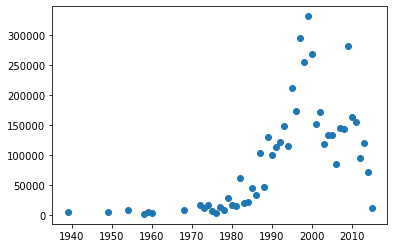

In [83]:

def year_sum(df):
    dictt={}
    for i in range(len(df)):
        current_year=df.loc[i,"Year"]
        if current_year in dictt:
            dictt[current_year]=dictt[current_year] + df.loc[i,"difference_words_m_f"]
        else:
            dictt[current_year]=df.loc[i,"difference_words_m_f"]
    return dictt
d=year_sum(df)
d=collections.OrderedDict(sorted(d.items()))
x=list(d.keys())
y=list(d.values())
plt.scatter(x,y)

In [84]:

###CI for Gross for male dominating movies
alpha = 0.05
n = len(df.loc[ df["difference_words_m_f"]>0 ])
a = min(df.loc[ df["difference_words_m_f"]>0 ,"Gross"])
b = max(df.loc[ df["difference_words_m_f"]>0 ,"Gross"])
delta = compute_epsilon(alpha,n,a,b)
mean_gross_male=np.mean(df.loc[ df["difference_words_m_f"]>0 ,"Gross"])
confidence_I_male=(mean_gross_male-delta,mean_gross_male+delta)

###CI for Gross for female dominating movies
alpha = 0.05
n = len(df.loc[ df["difference_words_m_f"]<0 ])
a = min(df.loc[ df["difference_words_m_f"]<0 ,"Gross"])
b = max(df.loc[ df["difference_words_m_f"]<0 ,"Gross"])
delta = compute_epsilon(alpha,n,a,b)
mean_gross_female=np.mean(df.loc[ df["difference_words_m_f"]<0 ,"Gross"])
confidence_I_female=(mean_gross_female-delta,mean_gross_female+delta)


In [85]:
import sklearn.model_selection as skms
import numpy as np
import sklearn.tree as skt
import sklearn.linear_model as sklm
import random
import sklearn.discriminant_analysis as skda
random.seed(2)
logistic_object=sklm.LogisticRegression(max_iter=10000)
decisiontree_object=skt.DecisionTreeClassifier(max_depth=10,criterion="entropy")
randomforest_object=ske.RandomForestClassifier(n_estimators=100,criterion="entropy")
objects=[logistic_object,decisiontree_object,randomforest_object]
for x in objects:
    boosting_object=ske.AdaBoostClassifier(base_estimator=x,n_estimators=10)
    X=df.iloc[:,0:13]
    y=df.iloc[:,13]
    k_folds_object=skms.StratifiedKFold(n_splits=10,shuffle=True)

    acc_score = []
    for train_index , test_index in k_folds_object.split(X,y):
        X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
        y_train , y_test = y[train_index] , y[test_index]
        
        boosting_object.fit(X_train,y_train)
        pred_values = boosting_object.predict(X_test)
        
        acc = skm.accuracy_score(pred_values , y_test)
        acc_score.append(acc)
    avg_acc_score = np.mean(acc_score)
    print("Average accuracy for:",x,avg_acc_score)

Average accuracy for: LogisticRegression(max_iter=10000) 0.9162994772218074
Average accuracy for: DecisionTreeClassifier(criterion='entropy', max_depth=10) 0.8854555638536221
Average accuracy for: RandomForestClassifier(criterion='entropy') 0.8989544436146378
